In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
OpenSSL             19.0.0
PIL                 6.2.0
anndata             0.7.5
anndata2ri          1.0.2
asn1crypto          1.0.1
backcall            0.1.0
bottleneck          1.2.1
cairo               1.19.0
certifi             2019.09.11
cffi                1.12.3
chardet             3.0.4
cloudpickle         1.2.2
colorama            0.4.1
cryptography        2.7
cycler              0.10.0
cython_runtime      NA
cytoolz             0.10.0
dask                2.5.2
dateutil            2.8.0
decorator           4.4.0
get_version         2.1
google              NA
gprofiler           1.0.0
h5py                2.10.0
idna                2.8
igraph              0.8.2
importlib_metadata  0.23
ipykernel           5.1.2
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.15.1
jinja2              2.10.3
joblib              0.13.2
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0

Datasets need to be merged into a single AnnData object before they can be integrated. For the healthy datasets, I'm only using the granja, oetjen, petti and van Galen datasets and excluding the han and wu datasets because they contained too few genes and I should have enough cells/donors without them.

In [2]:
# read in datasets
gran = sc.read('../data/granja/granja.h5ad')
gran.obs['dataset'] = 'granja'
gran.obs['sample'] = gran.obs['Group']
gran.obs['donor'] = gran.obs['sample'].str.extract(r'(_D[1-3])')[0].str.extract(r'(D[1-3])')
gran.obs = gran.obs[['dataset', 'sample', 'donor', 'celltype']]
gran.X = gran.layers['counts'].copy()
del gran.uns, gran.layers['counts']
gran

AnnData object with n_obs × n_vars = 20558 × 20287
    obs: 'dataset', 'sample', 'donor', 'celltype'

In [3]:
vang = sc.read('../data/van_Galen/van_Galen_healthy.h5ad')
vang.obs = vang.obs[['dataset', 'sample', 'donor', 'celltype']]
vang.X = vang.layers['counts'].copy()
del vang.uns, vang.obsm, vang.varm, vang.obsp, vang.layers['counts'], vang.var['highly_variable'], vang.var['means'], vang.var['dispersions'], vang.var['dispersions_norm']
vang

AnnData object with n_obs × n_vars = 7698 × 27899
    obs: 'dataset', 'sample', 'donor', 'celltype'

In [4]:
oet = sc.read('../data/oetjen/oetjen.h5ad')
oet.obs['dataset'] = 'oetjen'
oet.obs['donor'] = oet.obs['patient']
oet.obs = oet.obs[['dataset', 'sample', 'donor', 'celltype']]
oet.X = oet.layers['counts'].copy()
del oet.layers['counts'], oet.uns, oet.obsm, oet.varm, oet.obsp, oet.var['highly_variable'], oet.var['means'], oet.var['dispersions'], oet.var['dispersions_norm']
oet

AnnData object with n_obs × n_vars = 73050 × 33694
    obs: 'dataset', 'sample', 'donor', 'celltype'

In [5]:
pet = sc.read('../data/petti/petti_healthy.h5ad')
pet.obs['dataset'] = 'petti'
pet.obs['donor'] = pet.obs['sample'].str.extract(r'([0-9]+)')
pet.obs = pet.obs[['dataset', 'sample', 'donor', 'celltype']]
pet.X = pet.layers['counts'].copy()
del pet.layers['counts'], pet.obsm, pet.obsp, pet.uns, pet.varm, pet.var['highly_variable'], pet.var['means'], pet.var['dispersions'], pet.var['dispersions_norm']
pet

AnnData object with n_obs × n_vars = 18471 × 33538
    obs: 'dataset', 'sample', 'donor', 'celltype'

In [6]:
# merge adatas
datasets = [gran, oet, vang, pet]
adata_merge = datasets[0].concatenate(datasets[1:4], join='inner')
print(adata_merge.shape)

/home/sennis/anaconda3/lib/python3.7/site-packages/anndata/_core/merge.py:894: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,


(119777, 19365)


In [7]:
# filter out genes expressed in less than 3 cells
sc.pp.filter_genes(adata_merge, min_cells = 3)
print(adata_merge.shape)

filtered out 2394 genes that are detected in less than 3 cells
(119777, 16971)


In [9]:
# write out results
adata_merge.write('../data/healthy_merge.h5ad')

... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'donor' as categorical


To normalise the data, I'm going to use scran's function for normalisation in clusters.

In [3]:
# normalise inner-join data
#Perform a clustering for scran normalisation in clusters
adata_pp = adata_merge.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e4)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

NameError: name 'adata_w_han' is not defined

In [12]:
#Preprocess variables for scran normalisation
input_groups = adata_pp.obs['groups']
data_mat = adata_merge.X.T

In [13]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: 'BiocGenerics'


R[write to console]: The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from 'package:Matrix':

    which


R[write to console]: The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce,

In [14]:
#Delete adata_pp
del adata_pp
#Keep the count data in a counts layer
adata_merge.layers["counts"] = adata_merge.X.copy()
#Normalise adata 
adata_merge.obs['size_factors'] = size_factors
adata_merge.X /= adata_merge.obs['size_factors'].values[:,None]
adata_merge.X = sp.sparse.csr_matrix(adata_merge.X)
sc.pp.log1p(adata_merge)
# write out file with normalised data
adata_merge.write('../data/healthy_merge.h5ad')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:20)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/sennis/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/sennis/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/sennis/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/sennis/anaconda3/lib/python3.

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:52)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:56)


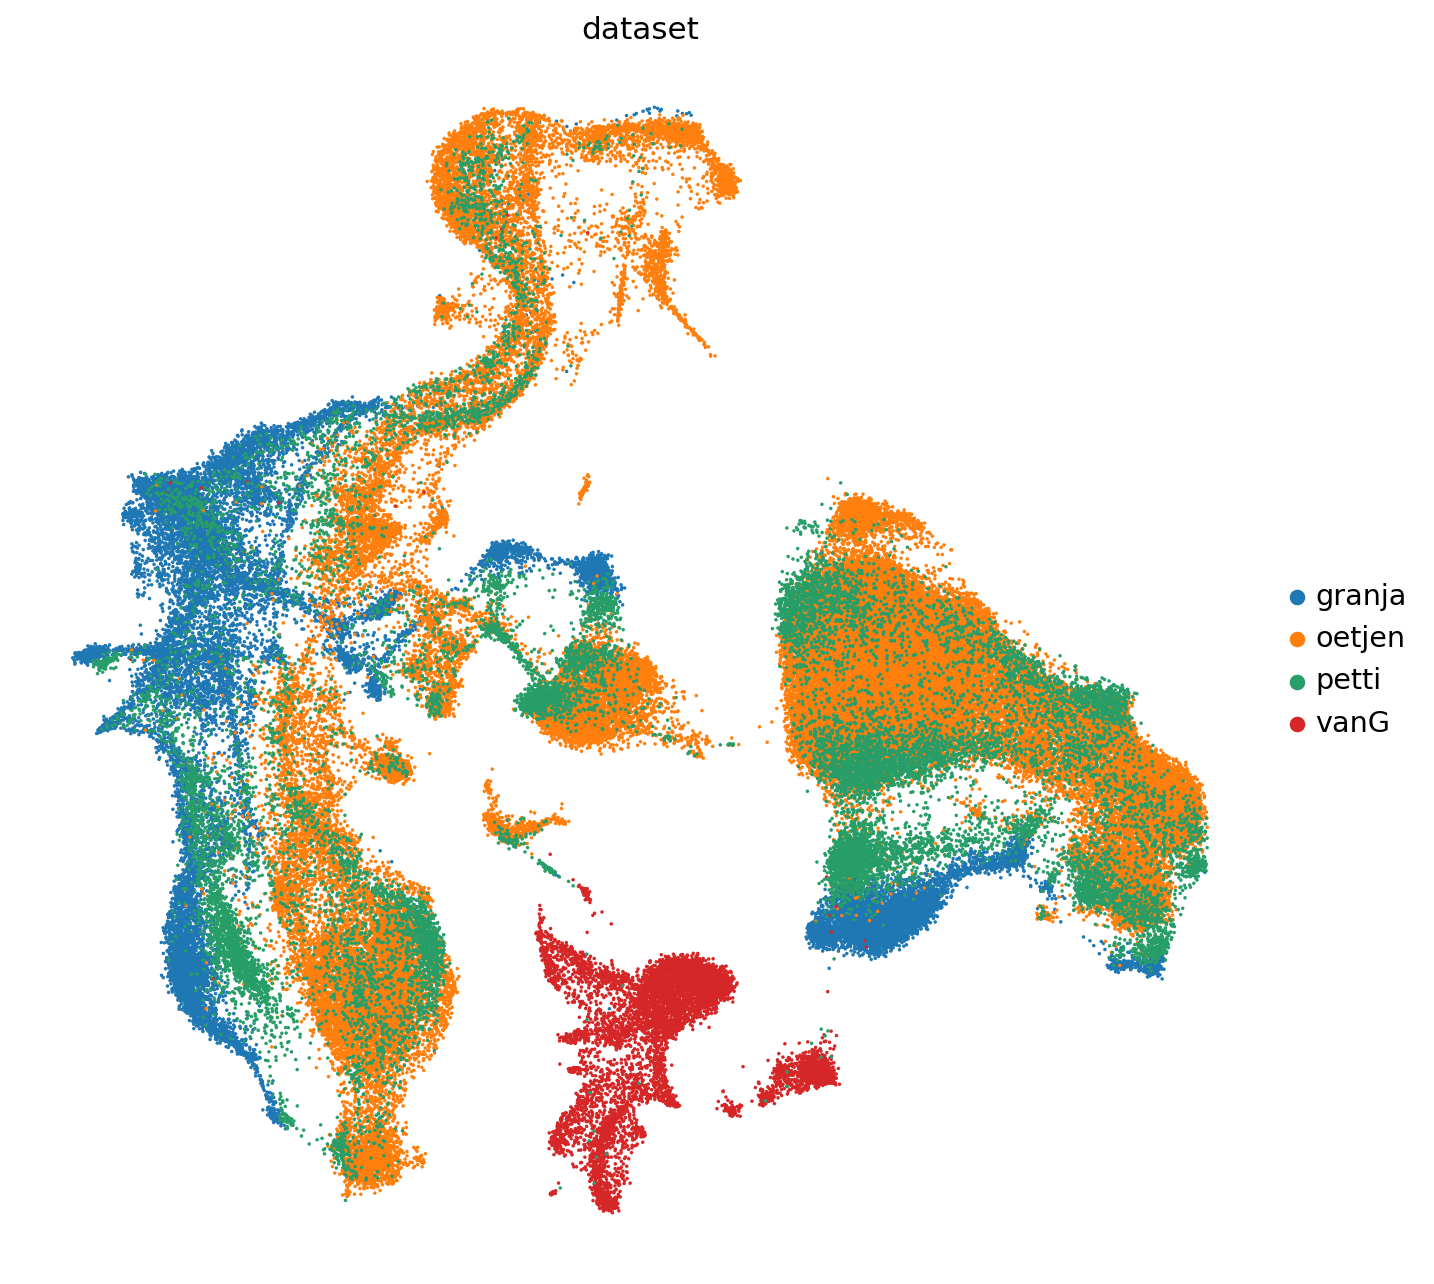

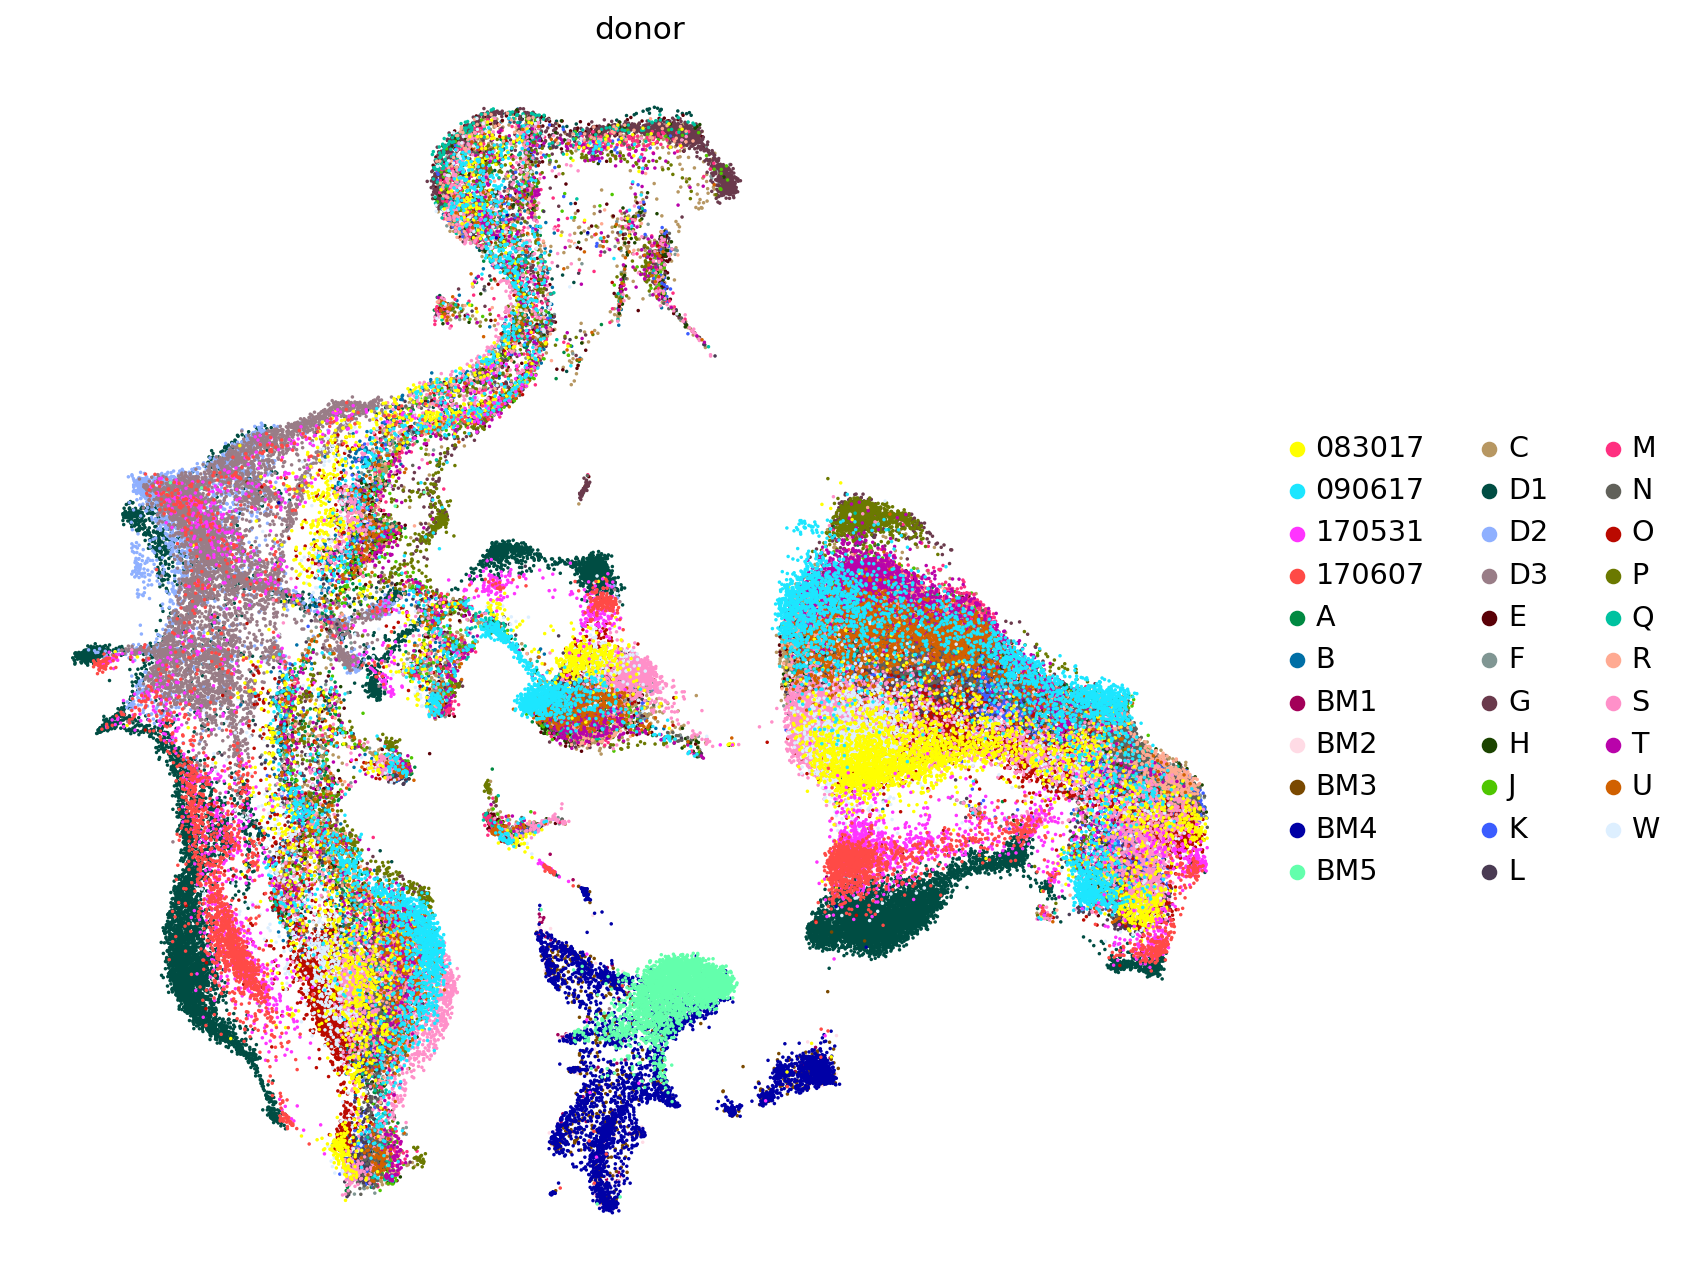

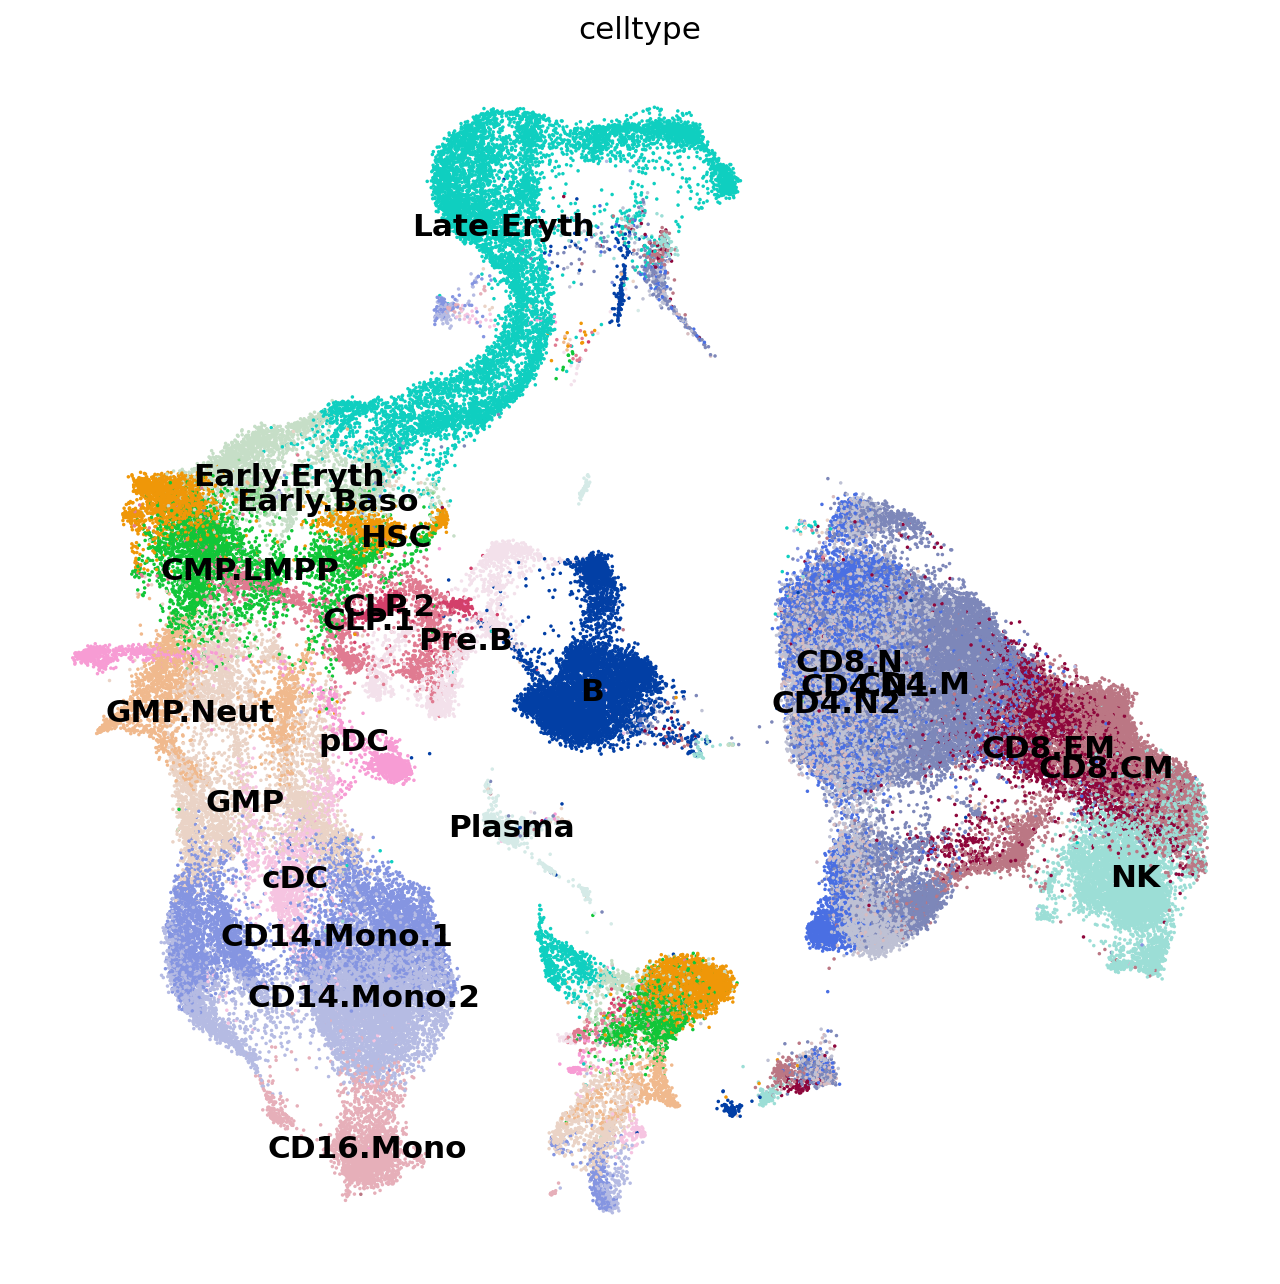

In [8]:
# Take a quick look at umap to see how pervasive the batch effect is
sc.pp.highly_variable_genes(adata_merge, n_top_genes=2000)
sc.pp.pca(adata_merge, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_merge)
sc.tl.umap(adata_merge)
sc.set_figure_params(figsize=(10, 10))
sc.pl.umap(adata_merge, color=['dataset'], frameon=False, wspace=0.6, size=10, ncols=1)
sc.pl.umap(adata_merge, color=['donor'], frameon=False, wspace=0.6, size=10, ncols=1)
sc.pl.umap(adata_merge, color=['celltype'], legend_loc='on data', frameon=False, wspace=0.6, size=10, ncols=1)